# Generate Spatial Signatures across GB

This notebook generates spatial signatures as a clustering of form and function characters.

In [ ]:
# pip install git+https://github.com/martinfleis/clustergram.git

In [1]:
import dask.dataframe
import numpy as np

from clustergram import Clustergram

In [2]:
standardized_form = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/form/standardized/").set_index('hindex')
stand_fn = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/function/standardized/")
data = dask.dataframe.multi.concat([standardized_form, stand_fn], axis=1).replace([np.inf, -np.inf], np.nan).fillna(0)

In [3]:
%time data = data.compute()

CPU times: user 2min 36s, sys: 1min 24s, total: 4min
Wall time: 2min 43s


In [4]:
data = data.drop(columns=["keep_q1", "keep_q2", "keep_q3"])

In [5]:
cgram = Clustergram(range(1, 25), method='minibatchkmeans', batch_size=1_000_000, n_init=100, random_state=42)
cgram.fit(data)

K=1 fitted in 780.0785899162292 seconds.
K=2 fitted in 864.1424376964569 seconds.
K=3 fitted in 954.2592947483063 seconds.
K=4 fitted in 1258.9098596572876 seconds.
K=5 fitted in 1360.8928196430206 seconds.
K=6 fitted in 1446.0337007045746 seconds.
K=7 fitted in 1550.0224254131317 seconds.
K=8 fitted in 1662.5290818214417 seconds.
K=9 fitted in 1759.5144119262695 seconds.
K=10 fitted in 1860.4208154678345 seconds.
K=11 fitted in 1957.2675037384033 seconds.
K=12 fitted in 2036.3741669654846 seconds.
K=13 fitted in 2098.1098449230194 seconds.
K=14 fitted in 2188.7303895950317 seconds.
K=15 fitted in 2251.541695833206 seconds.
K=16 fitted in 2390.264476776123 seconds.
K=17 fitted in 2506.9812376499176 seconds.
K=18 fitted in 2602.7613401412964 seconds.
K=19 fitted in 2642.102708339691 seconds.
K=20 fitted in 2746.4516792297363 seconds.
K=21 fitted in 2901.3386924266815 seconds.
K=22 fitted in 3010.796851873398 seconds.
K=23 fitted in 3055.145115852356 seconds.
K=24 fitted in 3155.79383182

In [9]:
labels = cgram.labels.copy()

In [10]:
labels.columns = labels.columns.astype("str")

In [11]:
labels.to_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/clustergram_labels.pq")

In [12]:
import urbangrammar_graphics as ugg
import seaborn as sns

sns.set(style='whitegrid')

CPU times: user 11min 28s, sys: 4min 51s, total: 16min 20s
Wall time: 3min 30s


(-30.0, 50.0)

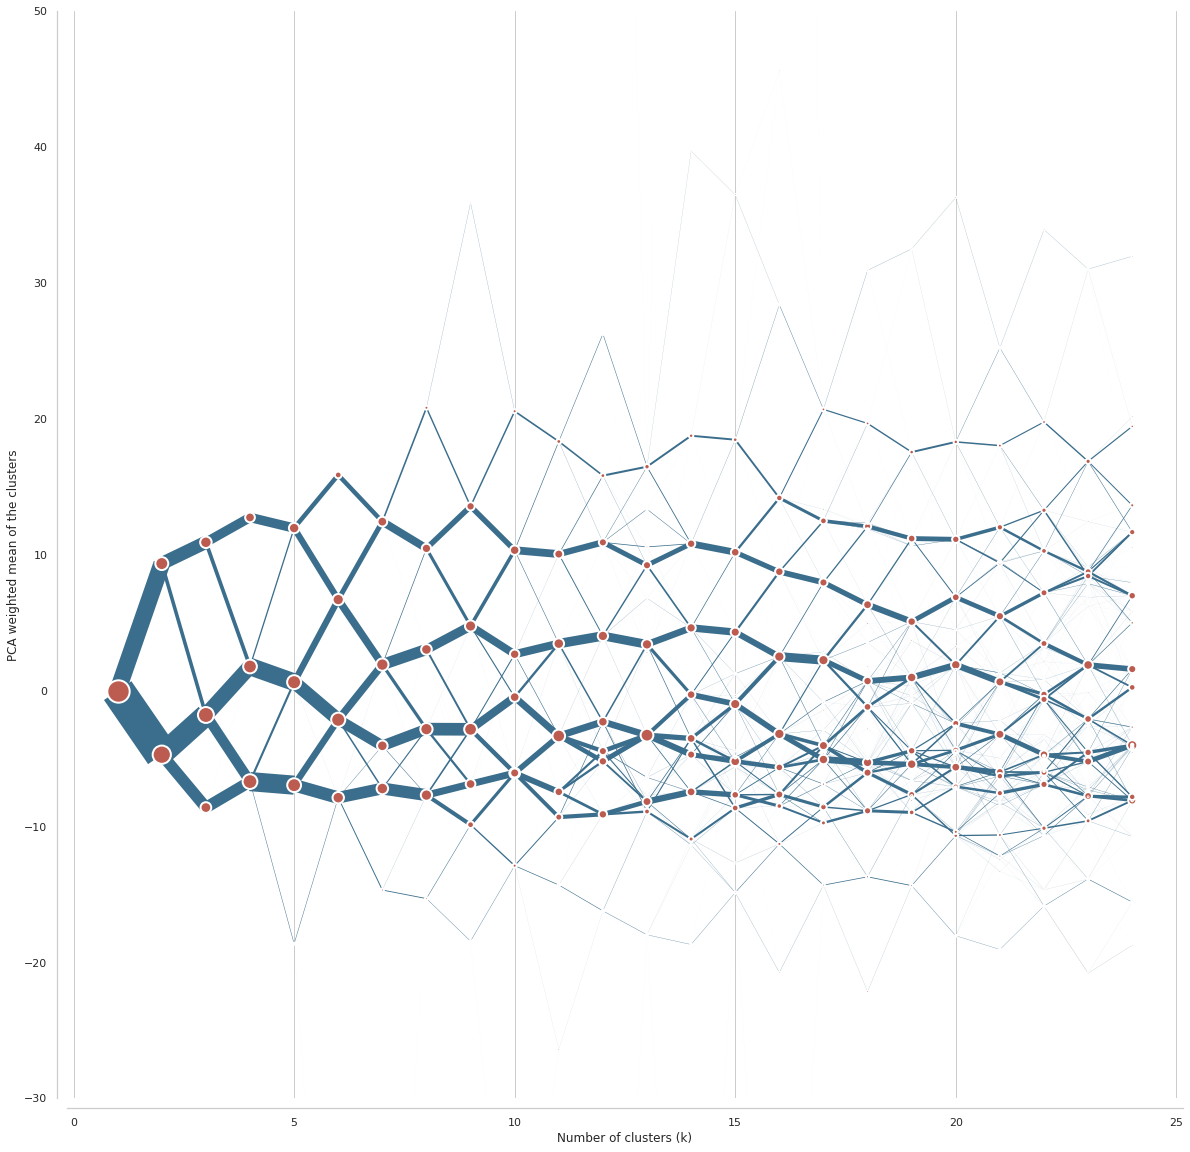

In [13]:
%%time

ax = cgram.plot(
    figsize=(20, 20),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_ylim(-30, 50)

In [36]:
from bokeh.io import output_notebook
from bokeh.plotting import show

output_notebook()

Loading BokehJS ...

In [17]:
fig = cgram.bokeh(
    figsize=(800, 600),
    line_style=dict(color=ugg.HEX[1]),
    cluster_style={"color": ugg.HEX[2]},
)
show(fig)

NameError: name 'cgram' is not defined

In [39]:
fig2 = cgram.bokeh(
    figsize=(800, 600),
    line_style=dict(color=ugg.HEX[1]),
    cluster_style={"color": ugg.HEX[2]},
    pca_weighted=False
)
show(fig2)

In [19]:
cgram.labels[10].value_counts()

5    3336758
4    2703587
3    2610026
1    2564843
6    2350191
0     486626
2     483285
8       3714
7        545
9          3
Name: 10, dtype: int64

<AxesSubplot:title={'center':'silhouette'}>

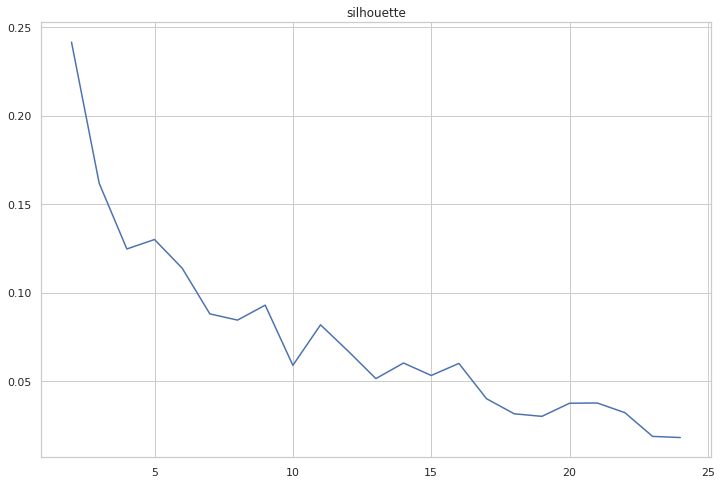

In [14]:
cgram.silhouette_score(sample_size=100_000)
cgram.silhouette.plot(figsize=(12, 8), title="silhouette")

<AxesSubplot:title={'center':'calinski_harabasz'}>

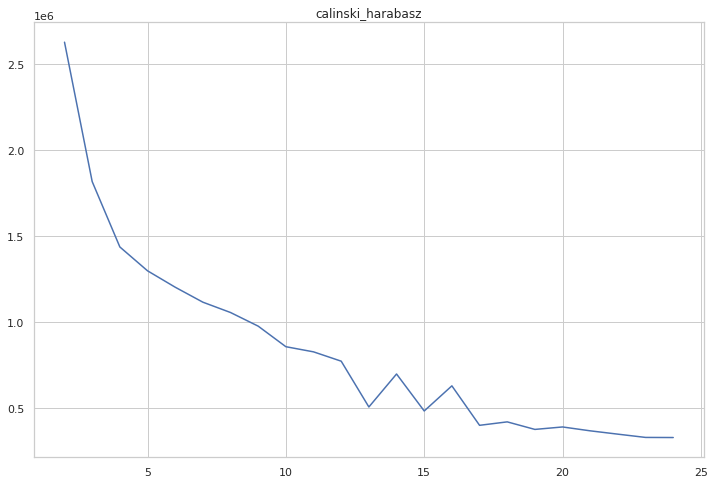

In [15]:
cgram.calinski_harabasz_score()
cgram.calinski_harabasz.plot(figsize=(12, 8), title="calinski_harabasz")

<AxesSubplot:title={'center':'davies_bouldin'}>

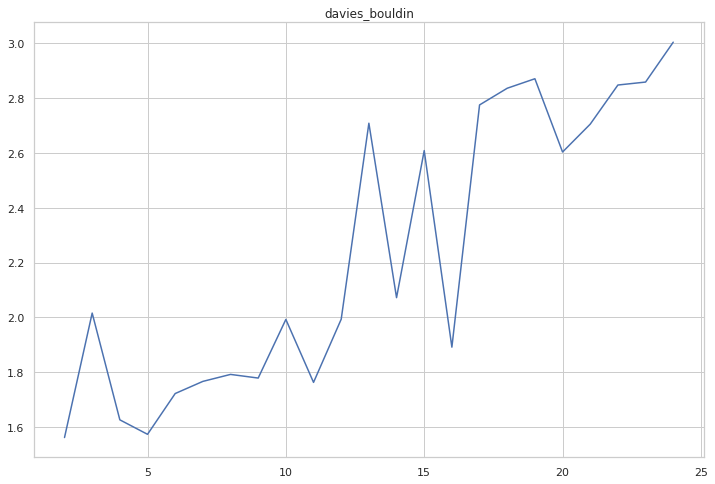

In [16]:
cgram.davies_bouldin_score()
cgram.davies_bouldin.plot(figsize=(12, 8), title="davies_bouldin")

In [40]:
import pickle

with open('../../urbangrammar_samba/spatial_signatures/clustering_data/clustergram.pickle','wb') as f:
    pickle.dump(cgram, f)

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import urbangrammar_graphics as ugg
import dask_geopandas
from utils.dask_geopandas import dask_dissolve

In [28]:
geom51 = gpd.read_parquet("../../urbangrammar_samba/spatial_signatures/tessellation/tess_51.pq", columns=["tessellation", "hindex"])
geom68 = gpd.read_parquet("../../urbangrammar_samba/spatial_signatures/tessellation/tess_68.pq", columns=["tessellation", "hindex"])

In [29]:
labels.index = data.index

In [30]:
geom51 = geom51.set_index("hindex")

In [31]:
geom51["cluster"] = labels["11"].loc[labels.index.str.startswith("c051")]

In [32]:
geom68 = geom68.set_index("hindex")
geom68["cluster"] = labels["11"].loc[labels.index.str.startswith("c068")]

In [33]:
cmap = ugg.get_colormap(16, randomize=True)

for i, geom in enumerate([geom51, geom68]):
    ddf = dask_geopandas.from_geopandas(geom.sort_values('cluster'), npartitions=64)
    spsig = dask_dissolve(ddf, by='cluster').compute().reset_index(drop=True).explode()
    
    token = "pk.eyJ1IjoibWFydGluZmxlaXMiLCJhIjoiY2tsNmhlemtxMmlicTJubXN6and5aTc2NCJ9.l7nSUXM7ZRjAWTB7oXiswQ"

    ax = spsig.plot("cluster", figsize=(20, 20), zorder=1, linewidth=.3, edgecolor='w', alpha=1, legend=True, cmap=cmap, categorical=True)
    ctx.add_basemap(ax, crs=27700, source=ugg.get_tiles('roads', token), zorder=2, alpha=.3)
    ctx.add_basemap(ax, crs=27700, source=ugg.get_tiles('labels', token), zorder=3, alpha=1)
    ctx.add_basemap(ax, crs=27700, source=ugg.get_tiles('background', token), zorder=-1, alpha=1)
    ax.set_axis_off()

    plt.savefig(f"../../urbangrammar_samba/spatial_signatures/clustering_data/validation/maps/fixed_option11_{i}.png")
    plt.close()   

In [35]:
geom15 = gpd.read_parquet("../../urbangrammar_samba/spatial_signatures/tessellation/tess_15.pq", columns=["tessellation", "hindex"])
geom15 = geom15.set_index("hindex")
geom15["cluster"] = labels["11"].loc[labels.index.str.startswith("c015")]
geom = geom15

# cmap = ugg.get_colormap(49, randomize=True)

ddf = dask_geopandas.from_geopandas(geom.sort_values('cluster'), npartitions=64)
spsig = dask_dissolve(ddf, by='cluster').compute().reset_index(drop=True).explode()

token = "pk.eyJ1IjoibWFydGluZmxlaXMiLCJhIjoiY2tsNmhlemtxMmlicTJubXN6and5aTc2NCJ9.l7nSUXM7ZRjAWTB7oXiswQ"

ax = spsig.plot("cluster", figsize=(20, 20), zorder=1, linewidth=.3, edgecolor='w', alpha=1, legend=True, cmap=cmap, categorical=True)
ctx.add_basemap(ax, crs=27700, source=ugg.get_tiles('roads', token), zorder=2, alpha=.3)
ctx.add_basemap(ax, crs=27700, source=ugg.get_tiles('labels', token), zorder=3, alpha=1)
ctx.add_basemap(ax, crs=27700, source=ugg.get_tiles('background', token), zorder=-1, alpha=1)
ax.set_axis_off()

plt.savefig(f"../../urbangrammar_samba/spatial_signatures/clustering_data/validation/maps/fixed_option11_london.png")
plt.close()   

## KMeans 10 clusters

In [1]:
import dask.dataframe
from sklearn.cluster import MiniBatchKMeans
import numpy as np

In [2]:
standardized_form = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/form/standardized/").set_index('hindex')
stand_fn = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/function/standardized/")
data = dask.dataframe.multi.concat([standardized_form, stand_fn], axis=1).replace([np.inf, -np.inf], np.nan).fillna(0)

In [3]:
%time data = data.compute()
data = data.drop(columns=["keep_q1", "keep_q2", "keep_q3"])

CPU times: user 2min 35s, sys: 1min 24s, total: 3min 59s
Wall time: 2min 42s


In [4]:
km = MiniBatchKMeans(n_clusters=10, batch_size=1_000_000, random_state=42, n_init=1000, verbose=1)
%time km.fit(data)

Init 1/1000 with method: k-means++
Inertia for init 1/1000: 624957313.651579
Init 2/1000 with method: k-means++
Inertia for init 2/1000: 629100300.505868
Init 3/1000 with method: k-means++
Inertia for init 3/1000: 634220163.152771
Init 4/1000 with method: k-means++
Inertia for init 4/1000: 611211236.905937
Init 5/1000 with method: k-means++
Inertia for init 5/1000: 634241407.492925
Init 6/1000 with method: k-means++
Inertia for init 6/1000: 656070645.110835
Init 7/1000 with method: k-means++
Inertia for init 7/1000: 637130619.775642
Init 8/1000 with method: k-means++
Inertia for init 8/1000: 612382814.291915
Init 9/1000 with method: k-means++
Inertia for init 9/1000: 616940448.830565
Init 10/1000 with method: k-means++
Inertia for init 10/1000: 624685814.486623
Init 11/1000 with method: k-means++
Inertia for init 11/1000: 615444889.620508
Init 12/1000 with method: k-means++
Inertia for init 12/1000: 608757280.659882
Init 13/1000 with method: k-means++
Inertia for init 13/1000: 61233889

MiniBatchKMeans(batch_size=1000000, n_clusters=10, n_init=1000, random_state=42,
                verbose=1)

In [5]:
import pandas as pd
labels = pd.Series(km.labels_, index=data.index, name="kmeans10gb")

In [6]:
pd.DataFrame(labels).to_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/KMeans10GB.pq")

In [7]:
labels = pd.DataFrame(labels)
labels

kmeans10gb
hindex                      
c000e094707t0000           4
c000e094763t0000           0
c000e094763t0001           0
c000e094763t0002           0
c000e094764t0000           0
...                      ...
c102e644989t0111           0
c102e644989t0112           0
c102e644989t0113           0
c102e644989t0114           0
c102e644989t0115           0

[14539578 rows x 1 columns]

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import urbangrammar_graphics as ugg
import dask_geopandas
from utils.dask_geopandas import dask_dissolve

In [9]:
import warnings 

warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

In [14]:
for i in range(103):
    geom = gpd.read_parquet(f"../../urbangrammar_samba/spatial_signatures/tessellation/tess_{i}.pq", columns=["tessellation", "hindex"]).set_index("hindex")
    geom = geom.merge(labels, how="left", left_index=True, right_index=True)


    ddf = dask_geopandas.from_geopandas(geom.sort_values('kmeans10gb'), npartitions=64)
    spsig = dask_dissolve(ddf, by='kmeans10gb').compute().reset_index(drop=True).explode()

    spsig.to_parquet(f"../../urbangrammar_samba/spatial_signatures/signatures/temp/spsig_{i}.pq")
    print(f"Chunk {i} done.")

Chunk 0 done.
Chunk 1 done.
Chunk 2 done.
Chunk 3 done.
Chunk 4 done.
Chunk 5 done.
Chunk 6 done.
Chunk 7 done.
Chunk 8 done.
Chunk 9 done.
Chunk 10 done.
Chunk 11 done.
Chunk 12 done.
Chunk 13 done.
Chunk 14 done.
Chunk 15 done.
Chunk 16 done.
Chunk 17 done.
Chunk 18 done.
Chunk 19 done.
Chunk 20 done.
Chunk 21 done.
Chunk 22 done.
Chunk 23 done.
Chunk 24 done.
Chunk 25 done.
Chunk 26 done.
Chunk 27 done.
Chunk 28 done.
Chunk 29 done.
Chunk 30 done.
Chunk 31 done.
Chunk 32 done.
Chunk 33 done.
Chunk 34 done.
Chunk 35 done.
Chunk 36 done.
Chunk 37 done.
Chunk 38 done.
Chunk 39 done.
Chunk 40 done.
Chunk 41 done.
Chunk 42 done.
Chunk 43 done.
Chunk 44 done.
Chunk 45 done.
Chunk 46 done.
Chunk 47 done.
Chunk 48 done.
Chunk 49 done.
Chunk 50 done.
Chunk 51 done.
Chunk 52 done.
Chunk 53 done.
Chunk 54 done.
Chunk 55 done.
Chunk 56 done.
Chunk 57 done.
Chunk 58 done.
Chunk 59 done.
Chunk 60 done.
Chunk 61 done.
Chunk 62 done.
Chunk 63 done.
Chunk 64 done.
Chunk 65 done.
Chunk 66 done.
Chunk

In [15]:
spsigs = pd.concat([gpd.read_parquet(f"../../urbangrammar_samba/spatial_signatures/signatures/temp/spsig_{i}.pq") for i in range(103)])

In [16]:
ddf = dask_geopandas.from_geopandas(spsigs.sort_values('kmeans10gb').reset_index(drop=True), npartitions=64)
spsig = dask_dissolve(ddf, by='kmeans10gb').compute().reset_index(drop=True).explode()

spsig.to_parquet(f"../../urbangrammar_samba/spatial_signatures/signatures/signatures_KMeans10_GB.pq")

In [2]:
spsig = gpd.read_parquet(f"../../urbangrammar_samba/spatial_signatures/signatures/signatures_KMeans10_GB.pq")

In [6]:
spsig

kmeans10gb                                       tessellation
0 0              0  POLYGON Z ((62220.000 798500.000 0.000, 62110....
  1              0  POLYGON Z ((63507.682 796515.169 0.000, 63471....
  2              0  POLYGON Z ((65953.174 802246.172 0.000, 65950....
  3              0  POLYGON Z ((67297.740 803435.800 0.000, 67220....
  4              0  POLYGON Z ((75760.000 852670.000 0.000, 75700....
...            ...                                                ...
9 1650           9  POLYGON Z ((654900.812 293684.702 0.000, 65490...
  1651           9  POLYGON Z ((655190.114 293670.165 0.000, 65514...
  1652           9  POLYGON Z ((655226.556 293769.886 0.000, 65522...
  1653           9  POLYGON Z ((655281.503 293499.471 0.000, 65527...
  1654           9  POLYGON Z ((655319.611 293315.223 0.000, 65532...

[87531 rows x 2 columns]

In [7]:
ddf = dask_geopandas.from_geopandas(spsig.reset_index().rename_geometry("geometry"), npartitions=64)
ddf.geometry = ddf.simplify(2).buffer(.001)

/opt/conda/lib/python3.8/site-packages/dask_geopandas/backends.py:31: FutureWarning: The input object of type 'LineString' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'LineString', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a = np.array(
/opt/conda/lib/python3.8/site-packages/dask_geopandas/backends.py:31: FutureWarning: The input object of type 'LineString' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'LineString', or

In [8]:
%time spsig = ddf.compute()

CPU times: user 16min 47s, sys: 2min 30s, total: 19min 18s
Wall time: 13min 8s


In [9]:
spsig

level_0  level_1  kmeans10gb  \
0            0        0           0   
1            0        1           0   
2            0        2           0   
3            0        3           0   
4            0        4           0   
...        ...      ...         ...   
87526        9     1650           9   
87527        9     1651           9   
87528        9     1652           9   
87529        9     1653           9   
87530        9     1654           9   

                                                geometry  
0      POLYGON ((62219.999 798499.999, 62110.000 7985...  
1      POLYGON ((63507.682 796515.168, 63507.682 7965...  
2      POLYGON ((65953.174 802246.171, 65953.174 8022...  
3      POLYGON ((67297.740 803435.799, 67220.290 8034...  
4      POLYGON ((75760.000 852669.999, 75760.000 8526...  
...                                                  ...  
87526  POLYGON ((654900.812 293684.701, 654900.812 29...  
87527  POLYGON ((655190.114 293670.166, 655190.115 29...  
87528  POLYGON ((655226.557 293769.887, 655236.405 29...  
87529  POLYGON ((655281.502 293499.470, 655281.502 29...  
87530  POLYGON ((655319.611 293315.224, 655319.611 29...  

[87531 rows x 4 columns]

In [13]:
ddf = dask_geopandas.from_geopandas(spsig, npartitions=64)
ddf.geometry = ddf.simplify(2)
%time spsig = ddf.compute()

/opt/conda/lib/python3.8/site-packages/dask_geopandas/backends.py:31: FutureWarning: The input object of type 'LineString' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'LineString', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a = np.array(
/opt/conda/lib/python3.8/site-packages/dask_geopandas/backends.py:31: FutureWarning: The input object of type 'LineString' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'LineString', or

CPU times: user 2min 11s, sys: 1.05 s, total: 2min 12s
Wall time: 15.2 s


In [14]:
spsig.to_file(f"../../urbangrammar_samba/spatial_signatures/signatures/signatures_KMeans10_GB_simplified.geojson", driver="GeoJSON")

In [15]:
spsig.to_parquet(f"../../urbangrammar_samba/spatial_signatures/signatures/signatures_KMeans10_GB_simplified.pq")

<ipython-input-15-1ea1c7da5570>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  spsig.to_parquet(f"../../urbangrammar_samba/spatial_signatures/signatures/signatures_KMeans10_GB_simplified.pq")


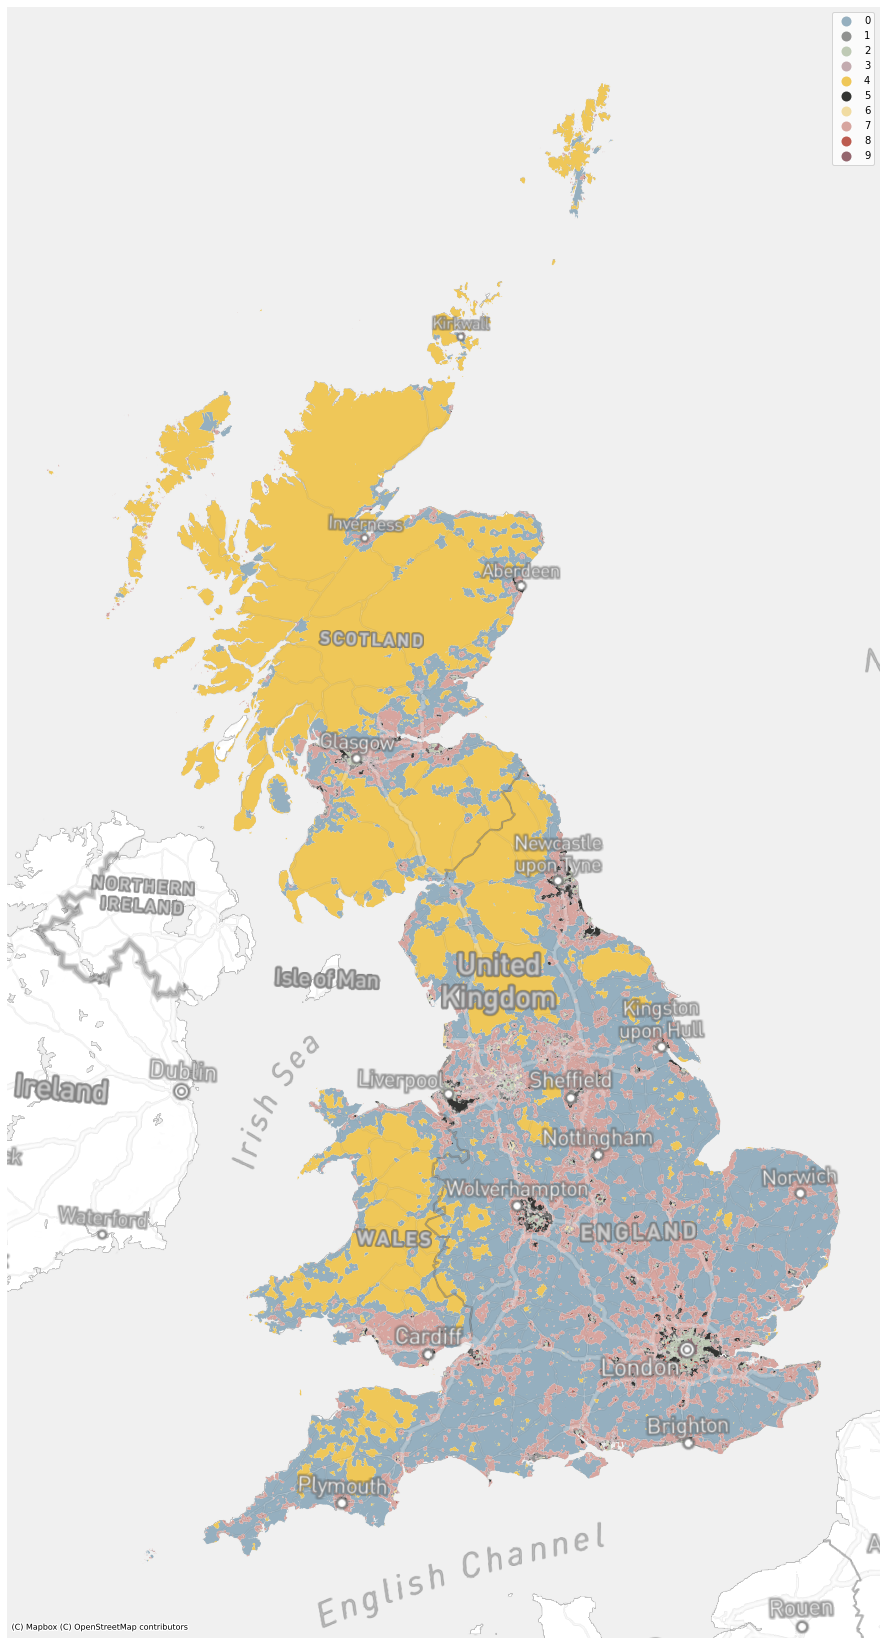

In [16]:
cmap = ugg.get_colormap(10, randomize=True)

token = "pk.eyJ1IjoibWFydGluZmxlaXMiLCJhIjoiY2tsNmhlemtxMmlicTJubXN6and5aTc2NCJ9.l7nSUXM7ZRjAWTB7oXiswQ"

ax = spsig.plot("kmeans10gb", figsize=(20, 30), zorder=1, linewidth=0, edgecolor='w', alpha=1, legend=True, cmap=cmap, categorical=True)
ctx.add_basemap(ax, crs=27700, source=ugg.get_tiles('roads', token), zorder=2, alpha=.3)
ctx.add_basemap(ax, crs=27700, source=ugg.get_tiles('labels', token), zorder=3, alpha=1)
ctx.add_basemap(ax, crs=27700, source=ugg.get_tiles('background', token), zorder=-1, alpha=1)
ax.set_axis_off()

plt.savefig(f"../../urbangrammar_samba/spatial_signatures/signatures/signatures_KMeans10_GB.png")